In [1]:
from config import setup, import_and_display_fnc

setup()

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2.mesh import (
    gauss_rule,
    stage1_refine,
    build_stage2_panel_surf,
    apply_interp_mat,
)

In [3]:
max_curvature = 0.25
t = sp.var("t")
(circle,) = stage1_refine(
    [
        (t, sp.cos(sp.pi * t), sp.sin(sp.pi * t)),
    ],
    gauss_rule(12),
    max_curvature=max_curvature,
    control_points=np.array([[1,0,0,0.1]])
)

In [13]:
from tectosaur2.mesh import pts_grid, upsample
from tectosaur2.laplace2d import double_layer
nobs = 300
zoomx = [0.75, 1.25]
zoomy = [0.0, 0.5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obs_pts.shape

(90000, 2)

In [14]:
%%time
upsampled_src, interp = upsample(circle, 10)
high = double_layer._direct(obs_pts, upsampled_src)
mat_upsampled = apply_interp_mat(high, interp)

CPU times: user 10.4 s, sys: 3.35 s, total: 13.8 s
Wall time: 13.2 s


In [15]:
mat_upsampled.shape

(90000, 408, 1)

In [16]:
I = double_layer.integrate(obs_pts, circle,tol = 1e-13, d_cutoff = 1.6, d_refine = 2.0,d_up = 3.31236863, d_qbx = 0.21499085, on_src_direction=1.0, return_report=True)

In [1]:
from line_profiler import LineProfiler
lp = LineProfiler()
print("HI", flush=True)
lp_wrapper = lp(double_layer.integrate)

lp.print_stats()

In [1]:
lp.print_stats()

NameError: name 'lp' is not defined

In [20]:
%%time
mat, report = double_layer.integrate(
    obs_pts,
    circle,
    tol = 1e-8,
    d_cutoff = 1.6,
    kappa = 4,
    d_up = [3.31236863, 0.53496603, 0.30958682, 0.21499085],
    on_src_direction=1.0,
    return_report=True,
)

TypeError: integrate() got an unexpected keyword argument 'kappa'

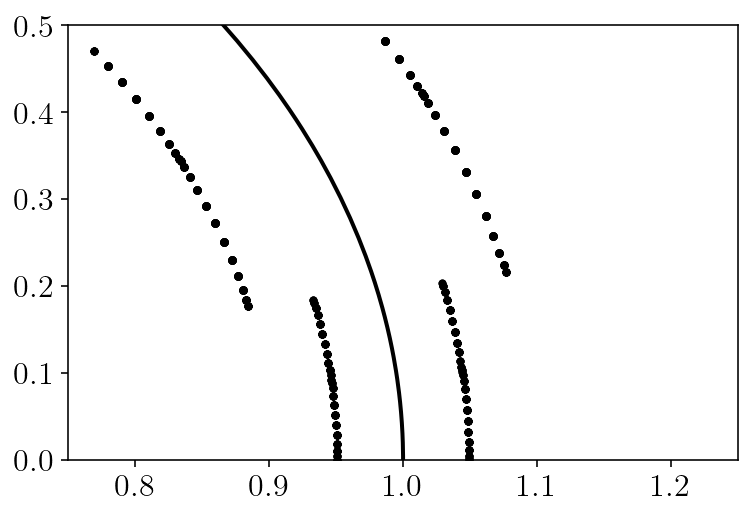

<ipython-input-60-ee2f81b5c870>:12: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(est - check)).reshape((nobs, nobs))


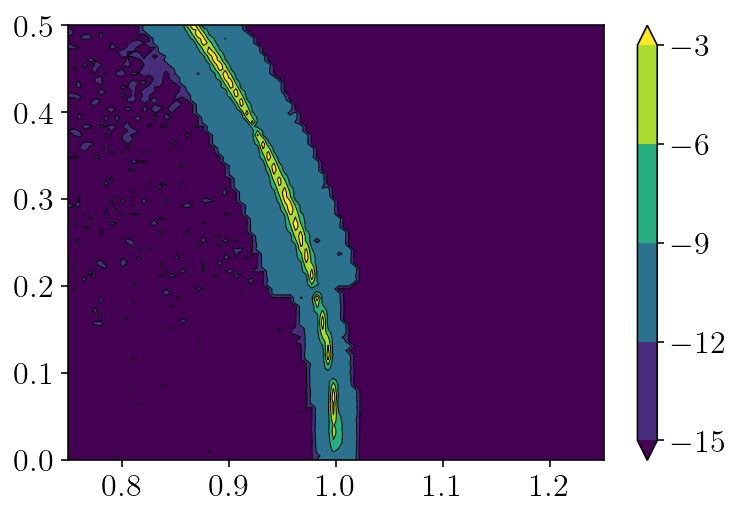

In [60]:
plt.plot(report['exp_centers'][:,0], report['exp_centers'][:,1], 'k.')
plt.plot(src.pts[:,0], src.pts[:,1],'k-')
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

density = np.cos(src.pts[:,0]**2)
check = mat_upsampled.dot(density)

est = mat.dot(density)

logerror = np.log10(np.abs(est - check)).reshape((nobs, nobs))
logerror[np.isinf(logerror)] = -17.0
error_levels = np.linspace(-15, -3, 5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(
    xs,
    ys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()

```
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    16                                               def integrate(
    17                                                   self,
    18                                                   obs_pts,
    19                                                   src,
    20                                                   tol=1e-13,
    21                                                   max_p=50,
    22                                                   on_src_direction=1.0,
    23                                                   return_report=False,
    24                                                   d_cutoff=None,
    25                                                   d_up=None,
    26                                                   kappa_qbx=None,
    27                                               ):
    28         1          3.0      3.0      0.0          if d_cutoff is None:
    29                                                       d_cutoff = self.d_cutoff
    30         1          2.0      2.0      0.0          if d_up is None:
    31                                                       d_up = self.d_up
    32         1          1.0      1.0      0.0          if kappa_qbx is None:
    33                                                       kappa_qbx = self.kappa_qbx
    34                                                   # step 1: construct the farfield matrix!
    35         1    1028195.0 1028195.0     11.9          mat = self._direct(obs_pts, src)
    36                                           
    37                                                   # step 2: identify QBX observation points.
    38         1        223.0    223.0      0.0          src_tree = scipy.spatial.KDTree(src.pts)
    39         1      72397.0  72397.0      0.8          closest_dist, closest_idx = src_tree.query(obs_pts)
    40         1       2063.0   2063.0      0.0          closest_panel_length = src.panel_length[closest_idx // src.panel_order]
    41         1        223.0    223.0      0.0          use_qbx = closest_dist < d_up[-1] * closest_panel_length
    42         1       2898.0   2898.0      0.0          qbx_closest_pts = src.pts[closest_idx][use_qbx]
    43         1       2924.0   2924.0      0.0          qbx_normals = src.normals[closest_idx][use_qbx]
    44         1        610.0    610.0      0.0          qbx_obs_pts = obs_pts[use_qbx]
    45         1         89.0     89.0      0.0          qbx_L = closest_panel_length[use_qbx]
    46                                           
    47                                                   # step 3: find expansion centers
    48                                                   # TODO: account for singularities
    49         1         35.0     35.0      0.0          exp_rs = qbx_L * 0.5
    50         1          2.0      2.0      0.0          direction_dot = (
    51         1        579.0    579.0      0.0              np.sum(qbx_normals * (qbx_obs_pts - qbx_closest_pts), axis=1) / exp_rs
    52                                                   )
    53         1         58.0     58.0      0.0          direction = np.sign(direction_dot)
    54         1         44.0     44.0      0.0          direction[np.abs(direction) < 1e-13] = on_src_direction
    55         1          2.0      2.0      0.0          exp_centers = (
    56         1        327.0    327.0      0.0              qbx_closest_pts + direction[:, None] * qbx_normals * exp_rs[:, None]
    57                                                   )
    58                                           
    59                                                   # step 4: refine the
    60         2     216005.0 108002.5      2.5          refined_src, interp_mat, refinement_plan = stage2_refine(
    61         1          1.0      1.0      0.0              src, exp_centers, kappa=kappa_qbx, distance_limit=2.01
    62                                                   )
    63         3         76.0     25.3      0.0          refinement_map = np.unique(
    64         1          6.0      6.0      0.0              refinement_plan[:, 0].astype(int), return_inverse=True
    65         1          2.0      2.0      0.0          )[1]
    66                                           
    67         1        166.0    166.0      0.0          n_qbx = np.sum(use_qbx)
    68         1          3.0      3.0      0.0          if n_qbx > 0:
    69                                                       # step 4: find which source panels need to use QBX
    70                                                       # this information must be propagated to the refined panels.
    71         1          4.0      4.0      0.0              (
    72         1          2.0      2.0      0.0                  qbx_refined_panels,
    73         1          2.0      2.0      0.0                  qbx_refined_panel_starts,
    74         1          2.0      2.0      0.0                  qbx_unrefined_panels,
    75         1          2.0      2.0      0.0                  qbx_unrefined_panel_starts,
    76         2     154264.0  77132.0      1.8              ) = identify_nearfield_panels(
    77         1          2.0      2.0      0.0                  exp_centers,
    78         1         29.0     29.0      0.0                  d_cutoff * qbx_L,
    79         1          2.0      2.0      0.0                  src_tree,
    80         1          4.0      4.0      0.0                  src.panel_order,
    81         1          2.0      2.0      0.0                  refinement_map,
    82                                                       )
    83                                           
    84                                                       # step 5: QBX integrals
    85                                                       # TODO: This could be replaced by a sparse local matrix.
    86         2         31.0     15.5      0.0              qbx_refined_mat = np.zeros(
    87         1         11.0     11.0      0.0                  (qbx_obs_pts.shape[0], refined_src.n_pts, self.ndim)
    88                                                       )
    89         2     855279.0 427639.5      9.9              p, kappa_too_small = local_qbx_integrals(
    90         1          2.0      2.0      0.0                  self.exp_deriv,
    91         1          2.0      2.0      0.0                  self.eval_deriv,
    92         1          2.0      2.0      0.0                  qbx_refined_mat,
    93         1          2.0      2.0      0.0                  qbx_obs_pts,
    94         1          2.0      2.0      0.0                  refined_src,
    95         1          2.0      2.0      0.0                  exp_centers,
    96         1          2.0      2.0      0.0                  exp_rs,
    97         1          2.0      2.0      0.0                  max_p,
    98         1          2.0      2.0      0.0                  tol,
    99         1          1.0      1.0      0.0                  qbx_refined_panels,
   100         1          1.0      1.0      0.0                  qbx_refined_panel_starts,
   101                                                       )
   102         1         63.0     63.0      0.0              if np.any(kappa_too_small):
   103                                                           warnings.warn("Some integrals diverged because kappa is too small.")
   104         2      56974.0  28487.0      0.7              qbx_mat = np.ascontiguousarray(
   105         1     410366.0 410366.0      4.7                  apply_interp_mat(qbx_refined_mat, interp_mat)
   106                                                       )
   107                                           
   108                                                       # step 6: subtract off the direct term whenever a QBX integral is used.
   109         1         37.0     37.0      0.0              correction_mat = np.zeros((qbx_obs_pts.shape[0], src.n_pts, self.ndim))
   110         2      14825.0   7412.5      0.2              self._nearfield(
   111         1          2.0      2.0      0.0                  correction_mat,
   112         1          2.0      2.0      0.0                  qbx_obs_pts,
   113         1          2.0      2.0      0.0                  src,
   114         1          2.0      2.0      0.0                  qbx_unrefined_panels,
   115         1          2.0      2.0      0.0                  qbx_unrefined_panel_starts,
   116         1          2.0      2.0      0.0                  -1.0,
   117                                                       )
   118         1      39386.0  39386.0      0.5              mat[use_qbx] += qbx_mat + correction_mat
   119                                           
   120                                                   # step 7: nearfield integrals
   121         1        380.0    380.0      0.0          use_nearfield = (closest_dist < d_up[0] * closest_panel_length) & (~use_qbx)
   122         1        206.0    206.0      0.0          n_nearfield = np.sum(use_nearfield)
   123                                           
   124         1          5.0      5.0      0.0          if n_nearfield > 0:
   125         1       2379.0   2379.0      0.0              nearfield_obs_pts = obs_pts[use_nearfield]
   126         1        199.0    199.0      0.0              nearfield_L = closest_panel_length[use_nearfield]
   127                                           
   128         1          5.0      5.0      0.0              (
   129         1          2.0      2.0      0.0                  nearfield_refined_panels,
   130         1          1.0      1.0      0.0                  nearfield_refined_panel_starts,
   131         1          2.0      2.0      0.0                  nearfield_unrefined_panels,
   132         1          2.0      2.0      0.0                  nearfield_unrefined_panel_starts,
   133         2    1740606.0 870303.0     20.1              ) = identify_nearfield_panels(
   134         1          2.0      2.0      0.0                  nearfield_obs_pts,
   135         1        130.0    130.0      0.0                  d_up[0] * nearfield_L,
   136         1          3.0      3.0      0.0                  src_tree,
   137         1          7.0      7.0      0.0                  src.panel_order,
   138         1          2.0      2.0      0.0                  refinement_map,
   139                                                       )
   140                                           
   141         2         30.0     15.0      0.0              nearfield_mat = np.zeros(
   142         1         10.0     10.0      0.0                  (nearfield_obs_pts.shape[0], refined_src.n_pts, self.ndim)
   143                                                       )
   144         2     366256.0 183128.0      4.2              self._nearfield(
   145         1          2.0      2.0      0.0                  nearfield_mat,
   146         1          2.0      2.0      0.0                  nearfield_obs_pts,
   147         1          2.0      2.0      0.0                  refined_src,
   148         1          2.0      2.0      0.0                  nearfield_refined_panels,
   149         1          2.0      2.0      0.0                  nearfield_refined_panel_starts,
   150         1          2.0      2.0      0.0                  1.0,
   151                                                       )
   152         2     463024.0 231512.0      5.3              nearfield_mat = np.ascontiguousarray(
   153         1    3064623.0 3064623.0     35.4                  apply_interp_mat(nearfield_mat, interp_mat)
   154                                                       )
   155         2      20426.0  10213.0      0.2              self._nearfield(
   156         1          2.0      2.0      0.0                  nearfield_mat,
   157         1          2.0      2.0      0.0                  nearfield_obs_pts,
   158         1          1.0      1.0      0.0                  src,
   159         1          2.0      2.0      0.0                  nearfield_unrefined_panels,
   160         1          2.0      2.0      0.0                  nearfield_unrefined_panel_starts,
   161         1          2.0      2.0      0.0                  -1.0,
   162                                                       )
   163         1     148870.0 148870.0      1.7              mat[use_nearfield] += nearfield_mat
   164                                           
   165         1          4.0      4.0      0.0          if return_report:
   166         1          4.0      4.0      0.0              report = dict()
   167         1          2.0      2.0      0.0              report["refined_src"] = refined_src
   168         1          2.0      2.0      0.0              report["interp_mat"] = interp_mat
   169                                           
   170        13         26.0      2.0      0.0              for k in [
   171                                                           "qbx_refined_mat",
   172                                                           "use_qbx",
   173                                                           "qbx_refined_panels",
   174                                                           "qbx_refined_panel_starts",
   175                                                           "n_qbx_panels",
   176                                                           "exp_centers",
   177                                                           "exp_rs",
   178                                                           "p",
   179                                                           "kappa_too_small",
   180                                                           "nearfield_refined_panels",
   181                                                           "nearfield_refined_panel_starts",
   182                                                           "n_nearfield_panels",
   183                                                       ]:
   184        12         52.0      4.3      0.0                  report[k] = locals().get(k, None)
   185         1         23.0     23.0      0.0              return np.transpose(mat, (0, 2, 1)), report
   186                                                   else:
   187                                                       return np.transpose(mat, (0, 2, 1))
```